In [2]:
from w2v_lda import *

In [44]:
%%time
wd_data=pd.read_parquet('data\patent_cut_doc.parquet')
co_data=pd.read_parquet('data\patent_co_ids.parquet')
patent_co=pd.read_csv('data\融资公司专利2024.csv',usecols=['序号','标题 (中文)', '摘要 (中文)','申请号','申请日','申请人','公开（公告）号','Co','table'])

df_co=pd.read_excel('data\公司融资变量2_20240301.xlsx',usecols=['公司序号','公司简称','工商全称','行业'])
co=df_co.loc[df_co.行业=='先进制造','工商全称'].unique()

Stopwords=set(read2list('data\\专利停用词表2024.txt'))
bd_word=pd.read_excel('data\\百度输入法词库1.xlsx',index_col=0)

CPU times: total: 1min 31s
Wall time: 1min 25s


In [13]:
wd_data.columns,co_data.columns,patent_co.columns

(Index(['序号', '词语'], dtype='object'),
 Index(['Co', '序号'], dtype='object'),
 Index(['序号', '标题 (中文)', '摘要 (中文)', '申请人', '申请日', '申请号', '公开（公告）号', 'table'], dtype='object'))

In [190]:
patent_co.shape,wd_data.shape

((1897517, 9), (1889962, 2))

In [253]:
patent_co['table'].value_counts()

table
patent202404                    846384
patent202210                    706371
patent_incopat_202101_202211    286413
patent_incopat_202212_202312     43636
patent202309                     14713
Name: count, dtype: int64

In [45]:
wd_data['词语']=wd_data['词语'].dropna().apply(lambda x: x.tolist())

In [347]:
patent_co_1=patent_co[patent_co['Co'].isin(co)].copy()
patent_co_1.申请日.min()

'1994-08-31'

In [349]:
patent_co_1['申请年']=pd.to_datetime(patent_co_1.申请日).dt.year
co_data_1=co_data[co_data.Co.isin(co)].copy()#patent_co_1['申请人'].str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).rename('Co')

In [204]:
co_data_1.shape,patent_co_1.Co.nunique()

((7370, 2), 7370)

In [350]:
(patent_co_1['申请年']==1994).sum()

4

  CBOW对小型数据库比较合适，而Skip-Gram在大型语料中表现更好。 当语料较少时使用CBOW方法比较好，当语料较多时采用skip-gram表示比较好。  

  主题模型是一种基于概率图模型的生成式模型，其似然函数可以写成若干条件概率连乘的形式，其中包括需要推测的隐含变量（即主题）；  
  而词嵌入模型一般表达为神经网络的形式，似然函数定义在网络的输出之上，需要通过学习网络的权重以得到单词的稠密向量表示。

  如果文档数量较少，Word2Vec（w2v）模型的相似度结果可能会变得不那么准确。    
词汇覆盖率低：文档少意味着训练数据少，许多词可能不会出现在训练集中，导致模型无法有效学习这些词的语义。  
语境信息不足：Word2Vec依赖于大量的上下文来学习词语之间的关系。文档少意味着模型能学习到的上下文信息有限，影响词向量的质量。  
过拟合风险高：在小数据集上训练的模型可能会过拟合，即过于贴合训练数据，而在新的数据上表现不佳。这样，模型可能会高估一些词之间的相似度，因为它们在训练集中偶然频繁地一起出现。   

文档数量和质量：
最小数量：一般来说，至少需要数千篇文档（或几十万到几百万的词）才能训练出一个有用的Word2Vec模型。如果文档太少，模型可能无法捕捉到足够的上下文信息来生成有意义的词向量。  
理想数量：为了获得更高质量的词向量，通常建议使用数百万篇文档（或数十亿个词）。

文档长度：
短文档：如果文档较短，例如社交媒体帖子或新闻摘要，那么需要更多的文档来覆盖足够的词汇和上下文。  
长文档：如果文档较长，例如书籍或长篇论文，那么较少的文档也能提供足够的上下文信息。

领域专注：
如果是在一个非常专门的领域（例如医学或法律），需要特定领域的大量文档来确保模型能够捕捉到该领域特有的词汇和语义。

一般应用：对于一般应用，如新闻分类或产品推荐，需要数百万到数千万的词。  
特定领域应用：对于特定领域的应用，建议收集尽可能多的领域相关文档，以确保模型能够准确地捕捉该领域的特定词汇和语义。

如果无法获得足够多的文档，可以考虑使用预训练的词向量（如Google的Word2Vec或GloVe）作为基础

In [49]:
len(patent_co_1),len(patent_co)#可先分个1000万专利上训练

(944627, 1897517)

In [35]:
patent_co_1['申请年'].value_counts()

申请年
2021    134978
2022    109812
2020    103997
2019     90856
2018     81509
2023     77849
2017     70823
2016     63691
2015     45376
2014     30713
2012     24362
2013     23642
2011     19393
2010     16845
2009     14284
2008     10735
2007     10550
2006      5599
2005      3185
2004      2006
2024      1537
2003      1459
2002       642
2001       426
2000       173
1999       132
1997        19
1998        14
1996         9
1995         7
1994         4
Name: count, dtype: int64

In [36]:
(patent_co_1['申请年']<=2000).sum()

358

w2v：尽可能多的训练，用已分词的  ：processed_doc,wd_data  
lda：用当前先进制造，每年训练主体标签和主题词不会统一  ：corpus,document_topics,documents_vec,df_lda_w2v  
结合：每年分开筛选，表示  :group_ids  


In [277]:
import w2v_lda
import importlib
importlib.reload(w2v_lda)
from w2v_lda import *

In [126]:
model=W2vLda(wd_data['词语'].dropna(),
             suffix='先进制造',
             stop_words=Stopwords
            )

In [ ]:
%%time
model.lda=1#不跑lda,先w2v
r1=model.on_corpus(vector_size=250,sg=1,window=5,count_fifter=5,min_count=3,no_below=3,num_topics=50,chunksize=3000,keep_n=800000,passes=3)
print(r1)
model.lda=None#重建corpus
filter_ids=patent_co.loc[patent_co['Co'].isin(co),'序号']
model.on_init(wd_data.loc[wd_data.序号.isin(filter_ids),'词语'].dropna(),suffix='先进制造')
r2=model.on_corpus()
print(r2)
model.save()

{'vector_size': 250, 'sg': 1, 'window': 5, 'len_below': 2, 'no_below': 3, 'min_count': 3, 'count_fifter': 5, 'num_topics': 50, 'top_n_words': 20, 'weight_threshold_topics': 0.03, 'chunksize': 3000, 'keep_n': 800000, 'passes': 3, 'top_n_topics': 3}


In [335]:
importlib.reload(w2v_lda)
from w2v_lda import *

model=W2vLda(wd_data['词语'].dropna(),
             suffix='188_27_sg',
             stop_words=Stopwords
            )
model.load(dictionary=False,lda=False)

In [336]:
model.on_init(wd_data.loc[wd_data.序号.isin(filter_ids),'词语'].dropna(),suffix='先进制造')
len(model.stop_words),len(model.sentences)

(6956, 1196876)

In [337]:
%%time
r2=model.on_corpus(count_fifter=5,min_count=3,no_below=3,num_topics=50,chunksize=3000,keep_n=800000,passes=3,no_above=0.99)#vector_size=250,sg=1,window=5,
print(r2)
model.save()

{'vector_size': 250, 'sg': 0, 'window': 5, 'len_below': 2, 'no_below': 3, 'min_count': 3, 'count_fifter': 5, 'num_topics': 50, 'top_n_words': 10, 'top_n_topics': 5, 'weight_threshold_topics': 0.05, 'minimum_probability': 0.05, 'chunksize': 3000, 'keep_n': 800000, 'passes': 3, 'no_above': 0.99}
(268220, 137899, 137899)
CPU times: total: 56min 52s
Wall time: 56min 55s


In [338]:
len(model.sentences),len(model.corpus)#model.wd_data.index

(1196876, 1196876)

In [339]:
len(model.wo.wv)

268220

In [340]:
%%time
topics_vec,documents_vec=model.on_topics(top_n_words=30, top_n_topics=4,minimum_probability=0.03,weight_threshold_topics=0.03)

CPU times: total: 11min 10s
Wall time: 11min 11s


In [344]:
np.save("data\\topics_vec_先进制造.npy",np.array(topics_vec))

In [3]:
topics_vec=np.load("data\\topics_vec_先进制造.npy")

In [341]:
df_topic=model.df_topics(topn=30)#top_n_words
df_topic#30*50

,word,0,word,1,word,2,word,3,word,4,...,word,45,word,46,word,47,word,48,word,49
0,控制,0.336473,壳体,0.060365,时间,0.137966,检测,0.434082,工件,0.171947,...,组件,0.104818,电机,0.166002,监测,0.180670,信号,0.229929,设备,0.691298
1,温度,0.093791,本体,0.052032,同步,0.073825,晶圆,0.070577,基底,0.107282,...,安装,0.066537,控制器,0.097613,场景,0.119917,功率,0.044660,对象,0.043946
2,模式,0.050696,结构,0.036464,时钟,0.069153,缺陷,0.039418,通讯,0.096650,...,机构,0.060612,物料,0.064860,开启,0.060530,输出,0.037771,极耳,0.026328
3,工作,0.031869,限位,0.035447,缓冲,0.056486,阈值,0.038228,神经网络,0.063235,...,固定,0.046357,转子,0.036421,关闭,0.053182,采样,0.032491,识别方法,0.013465
4,运行,0.027646,夹持,0.028398,翻转,0.047002,异常,0.034680,吸盘,0.052574,...,驱动,0.030306,轴承,0.034787,打开,0.051750,频率,0.026628,反射镜,0.011968
5,控制系统,0.022630,绝缘,0.024258,周期,0.040176,探针,0.021048,沟道,0.048676,...,支撑,0.025624,端盖,0.031197,跟踪,0.044414,输入,0.025969,铜箔,0.010763
6,启动,0.021287,导电,0.023150,锁定,0.033064,等于,0.017985,手机,0.033976,...,设有,0.021159,定子,0.029342,转运,0.034784,校准,0.020390,配置文件,0.006139
7,感应,0.016353,开口,0.020701,时序,0.032248,大于,0.017380,损失,0.030307,...,转动,0.020907,镀膜,0.020289,协同,0.031341,脉冲,0.015925,控制设备,0.006105
8,动作,0.014671,接触,0.019989,基准,0.027335,判断,0.017249,焊缝,0.029415,...,结构,0.017539,轴向,0.020029,绕线,0.021557,放大,0.015886,电动汽车,0.005813
9,转速,0.011540,通孔,0.019889,寄存器,0.026697,释放,0.012530,周围,0.027187,...,支架,0.015712,动力,0.016158,货物,0.020258,误差,0.015722,知识,0.005302


In [342]:
df_topic.to_excel('data\\patent_topic_words_先进制造.xlsx')

In [ ]:
%%time
topic_word_entropy=model.topic_word_entropy_corpus()

In [343]:
len(documents_vec)

1196876

In [233]:
pd.DataFrame({'vec': [vec for vec in documents_vec[:100]]})

,vec
0,"[0.20992305898202143, 0.0969748890390127, -0.0..."
1,"[0.20308027169142182, 0.09222375618223047, -0...."
2,"[0.210712741640104, 0.09495200047089854, -0.04..."
3,"[0.1374705665213969, 0.0203994829451518, -0.13..."
4,"[0.21568592993850627, 0.08380489735799194, -0...."
...,...
95,"[0.18576343369946371, 0.06688628962402177, -0...."
96,"[0.13336378913456595, 0.1165287368062044, -0.1..."
97,"[0.1285201007778851, 0.08362035207292037, -0.1..."
98,"[0.19523065835421713, -0.09120270779788076, -0..."


In [255]:
df_lda_w2v = pd.DataFrame(documents_vec, index=model.wd_data.index)
df_lda_w2v = df_lda_w2v[df_lda_w2v.sum(axis=1) != 0]
df_lda_w2v['序号'] = wd_data.loc[df_lda_w2v.index,'序号']  # df_lda_w2v.merge(id_data[['序号']], left_index=True, right_index=True, how='left')
df_lda_w2v.set_index('序号', inplace=True)
df_lda_w2v.to_parquet(f'data\\documents_vec_{model.suffix}.parquet')

In [686]:
%%time
df_lda_w2v=model.docs_vec(documents_vec,wd_data)
df_lda_w2v.head()

CPU times: total: 34.5 s
Wall time: 38.2 s


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
序号,,,,,,,,,,,,,,,,,,,,,
165,0.226318,0.078761,-0.008609,0.084645,-0.121523,0.050315,0.143755,0.139454,-0.081216,-0.039331,...,0.031926,-0.261344,0.038376,0.127057,0.249235,0.016564,-0.143402,-0.212742,0.049918,-0.094760
166,0.247366,0.092943,-0.021953,0.057754,-0.154601,0.039173,0.176503,0.154752,-0.075900,-0.036187,...,0.086806,-0.276183,0.034767,0.104448,0.249973,0.017978,-0.144689,-0.228626,0.014364,-0.124538
167,0.212533,0.117018,-0.017932,0.084564,-0.130198,-0.003878,0.145923,0.105760,-0.061761,-0.049846,...,0.018148,-0.239046,0.017226,0.140527,0.253161,0.010808,-0.153000,-0.231836,0.051671,-0.057798
330,0.070786,0.089471,-0.094590,0.032891,-0.002434,0.043171,0.042919,0.070739,-0.140479,-0.081115,...,-0.058568,-0.215066,0.042571,0.138493,0.127882,0.038323,-0.142864,-0.224343,0.042267,0.080659
344,0.273770,0.060962,0.042809,0.111510,-0.211537,0.026869,0.229101,0.164771,-0.017325,-0.047981,...,0.072181,-0.221300,0.016030,0.095175,0.146924,-0.028892,-0.149581,-0.179586,0.014032,-0.026649


In [680]:
np.save("data\\documents_vec_先进制造.npy",df_lda_w2v.values)

In [676]:
df_lda_w2v.to_hdf(f'data\\documents_vec_{model.suffix}.h5', key='df', mode='w')

C:\Users\Prime\AppData\Local\Temp\ipykernel_27584\108166792.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->axis0] [items->None]

  df_lda_w2v.to_hdf(f'data\\documents_vec_{model.suffix}.h5', key='df', mode='w')
C:\Users\Prime\AppData\Local\Temp\ipykernel_27584\108166792.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block0_items] [items->None]

  df_lda_w2v.to_hdf(f'data\\documents_vec_{model.suffix}.h5', key='df', mode='w')


In [357]:
df_lda_w2v.shape

(1196876, 250)

In [346]:
len(patent_co.loc[patent_co.序号.isin(filter_ids)]),len(patent_co_1)

(1204008, 1202962)

In [221]:
group_ids_1 = patent_co_1.groupby('Co')['序号'].apply(lambda x: x.to_list()).reset_index()
len(group_ids_1),len(co_data_1)

(7370, 7370)

In [225]:
co_ids_vec = group_ids_1['序号'].apply(lambda x: df_lda_w2v.loc[df_lda_w2v.index.isin(x)].mean(axis=0))#,np.mean(np.vstack(vectors), axis=0)
co_ids_vec.index = group_ids_1['Co']
co_ids_vec=co_ids_vec[co_ids_vec.sum(axis=1) != 0] 

In [227]:
co_ids_vec.to_parquet(f'data\patent_co_vec_先进制造.parquet')#
co_ids_vec.shape

(7370, 250)

In [74]:
arr=cosine_sim_arr(co_ids_vec)
arr.mean()

0.8795824828784314

In [5]:
import matplotlib.pyplot as plt

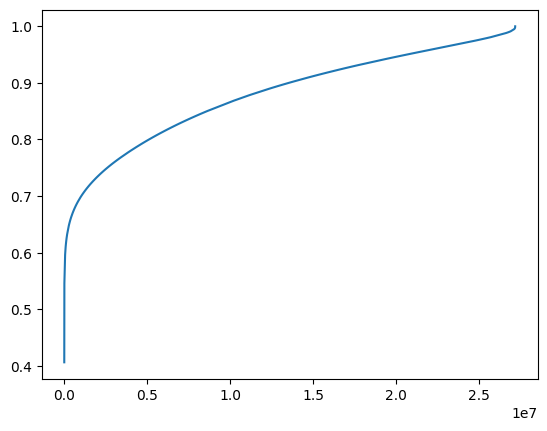

In [77]:
plt.plot(np.sort(arr))

In [244]:
df_lda_w2v_1 = pd.DataFrame(({'vec': [vec for vec in documents_vec]}, index=model.wd_data.index)
df_lda_w2v_1  = df_lda_w2v_1[df_lda_w2v_1['vec'].apply(np.sum) != 0]
df_lda_w2v_1['序号'] = wd_data.loc[df_lda_w2v_1.index,'序号']  # df_lda_w2v.merge(id_data[['序号']], left_index=True, right_index=True, how='left')
df_lda_w2v_1.set_index('序号', inplace=True)
df_lda_w2v_1.shape

(1197859, 1)

In [246]:
co_ids_vec = group_ids_1['序号'].apply(lambda x: df_lda_w2v_1.loc[df_lda_w2v_1.index.isin(x),'vec'].apply(pd.Series).mean(axis=0))

In [361]:
for i  in range(2000,2025):
    group_ids_t=patent_co_1[patent_co_1['申请年']<=i].groupby('Co')['序号'].apply(lambda x: x.to_list()).reset_index()
    co_ids_vec_t =group_ids_t['序号'].apply(lambda x: df_lda_w2v.loc[df_lda_w2v.index.isin(x)].mean(axis=0))
    co_ids_vec_t.index = group_ids_t['Co']
    co_ids_vec_t=co_ids_vec_t[co_ids_vec_t.sum(axis=1) != 0] 
    
    print(i,len(group_ids_t),len(co_ids_vec_t), cosine_sim_arr(co_ids_vec_t).mean())
    co_ids_vec_t.to_parquet(f'data\patent_co_vec_先进制造_{i}.parquet')

2000 20 20 0.8410943360013077
2001 36 36 0.8438048134920726
2002 52 51 0.8358112164424675
2003 68 67 0.8463742668463504
2004 87 85 0.8418154024884938
2005 108 105 0.8457371512802041
2006 156 152 0.8431780898746148
2007 228 223 0.8415669603593388
2008 335 327 0.8444184256888474
2009 453 450 0.8500302295190381
2010 614 612 0.8541669108859301
2011 820 818 0.8532844648311976
2012 1040 1038 0.8522086440276844
2013 1356 1354 0.8528266890283733
2014 1748 1746 0.8514832728890968
2015 2367 2366 0.8544592910140814
2016 3109 3108 0.8596518346675455
2017 3765 3765 0.8649895050464457
2018 4289 4289 0.8680361436169658
2019 4713 4713 0.8721550757551108
2020 5082 5082 0.8758058559739526
2021 6616 6616 0.874906331237934
2022 7048 7048 0.8782115078094669
2023 7362 7362 0.8794987219942204
2024 7370 7370 0.8795824828784314


In [15]:
co_ids_vec=pd.read_parquet(f'data\patent_co_vec_先进制造_{2024}.parquet')
co_ids_vec.shape

(7370, 250)

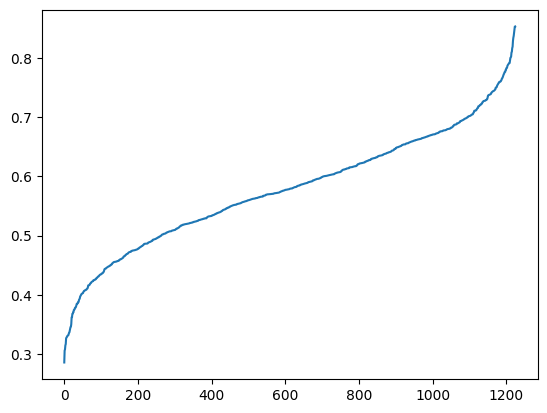

In [23]:
plt.plot(np.sort(cosine_sim_arr(topics_vec)))

In [36]:
co_topics=co_ids_vec.values @ topics_vec.T
co_topics.shape

(7370, 50)

In [82]:
pd.Series(co_topics.reshape(-1)).describe()

count    368500.000000
mean          3.352355
std           0.455572
min           2.064941
25%           3.074439
50%           3.271433
75%           3.520770
max           7.822679
dtype: float64

(array([1.1000e+01, 8.9000e+01, 4.7200e+02, 1.6890e+03, 4.6000e+03,
        9.1990e+03, 1.6515e+04, 2.8010e+04, 4.2445e+04, 5.4319e+04,
        5.3843e+04, 4.3889e+04, 3.0910e+04, 2.0448e+04, 1.4043e+04,
        1.0514e+04, 8.0450e+03, 6.4430e+03, 5.0670e+03, 3.9010e+03,
        3.3100e+03, 2.5490e+03, 1.9720e+03, 1.5100e+03, 1.1690e+03,
        8.9200e+02, 6.3000e+02, 4.8500e+02, 3.8400e+02, 2.7800e+02,
        2.0000e+02, 1.2800e+02, 1.1400e+02, 8.6000e+01, 6.9000e+01,
        6.5000e+01, 3.9000e+01, 3.7000e+01, 3.5000e+01, 2.6000e+01,
        1.8000e+01, 1.7000e+01, 1.3000e+01, 7.0000e+00, 4.0000e+00,
        5.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.0649406 , 2.18009538, 2.29525015, 2.41040493, 2.5255597 ,
        2.64071447, 2.75586925, 2.87102402, 2.9861788 , 3.10133357,
        3.21648834, 3.33164312, 3.44679789, 3.56195267, 3.67710744,
        3.79226221, 3.90741699, 4.02257176, 4.13772654, 4.25288131,
        4.36803608, 4.48319086, 4.59834563, 4.

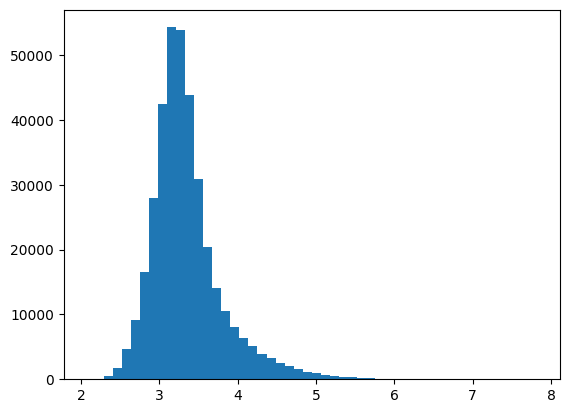

In [88]:
plt.hist(co_topics.reshape(-1),bins=50)

In [38]:
df_co_topics=pd.DataFrame(cosine_similarity(co_ids_vec.values, topics_vec),index=co_ids_vec.index)
df_co_topics #表示两个向量方向的相似性

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Co,,,,,,,,,,,,,,,,,,,,,
Dexta Robotics,0.739043,0.526914,0.746226,0.648772,0.700416,0.638908,0.577323,0.764137,0.588694,0.730758,...,0.511689,0.759001,0.634844,0.733174,0.795949,0.559348,0.564386,0.790428,0.757343,0.668402
TCL华星光电技术有限公司,0.695869,0.739076,0.738828,0.692714,0.849009,0.722517,0.709671,0.713045,0.680211,0.743885,...,0.695068,0.652561,0.814965,0.733867,0.696973,0.683842,0.675328,0.754451,0.717766,0.621930
TCL科技集团股份有限公司,0.703275,0.720896,0.710995,0.701465,0.837791,0.781507,0.759719,0.711789,0.788621,0.707181,...,0.773024,0.656050,0.826078,0.758151,0.681146,0.653901,0.684373,0.757966,0.664188,0.657162
一道新能源科技股份有限公司,0.675800,0.863493,0.665596,0.663891,0.793755,0.766248,0.820299,0.638908,0.694710,0.643554,...,0.782730,0.562666,0.803195,0.690564,0.611495,0.874698,0.755586,0.727479,0.584412,0.640316
七星电气股份有限公司,0.650250,0.917296,0.627181,0.598122,0.737906,0.743748,0.838272,0.580237,0.611189,0.619699,...,0.733328,0.511690,0.748424,0.661355,0.574008,0.930991,0.761210,0.701298,0.547456,0.595600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
黑龙江省发现者机器人股份有限公司,0.644865,0.883346,0.624683,0.593116,0.724113,0.740904,0.823702,0.574001,0.604680,0.592326,...,0.721220,0.503658,0.732717,0.627790,0.556346,0.947253,0.778015,0.690445,0.528910,0.601221
鼎桥通信技术有限公司,0.717446,0.698844,0.760800,0.670770,0.783920,0.707748,0.686666,0.757351,0.626409,0.706046,...,0.623023,0.781164,0.708004,0.779060,0.832714,0.693009,0.661057,0.804143,0.714736,0.769840
龙微科技无锡有限公司,0.682853,0.869073,0.665417,0.671429,0.801297,0.781580,0.845082,0.628923,0.712162,0.663424,...,0.795193,0.552076,0.852214,0.708059,0.625534,0.845724,0.744749,0.733619,0.608678,0.631341


(-0.5, 7369.5, 49.5, -0.5)

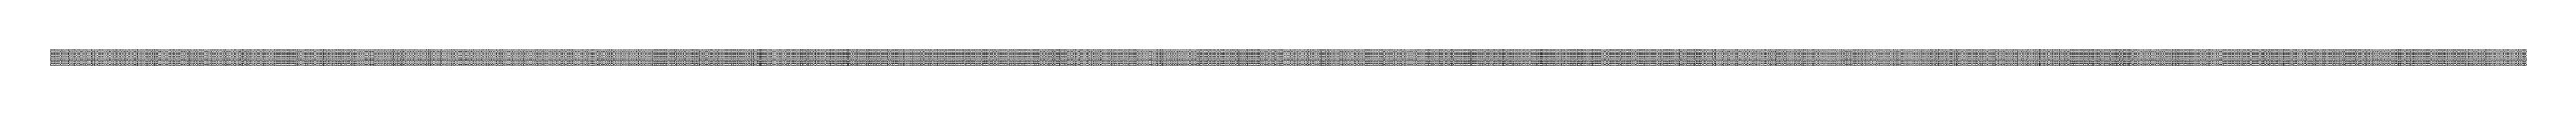

In [103]:
plt.figure(dpi=800) 
plt.imshow(df_co_topics.T, cmap='gray', interpolation='nearest' )
plt.axis('off')
#plt.colorbar()

In [54]:
df_co_topics.mean()

0     0.699002
1     0.760923
2     0.690696
3     0.658679
4     0.771884
5     0.735717
6     0.755048
7     0.668616
8     0.676886
9     0.681841
10    0.716701
11    0.661273
12    0.623235
13    0.748566
14    0.673517
15    0.684834
16    0.693977
17    0.769681
18    0.689150
19    0.766400
20    0.748283
21    0.673780
22    0.802683
23    0.728674
24    0.601050
25    0.747167
26    0.732719
27    0.717275
28    0.708394
29    0.730279
30    0.717960
31    0.697542
32    0.699134
33    0.600705
34    0.649368
35    0.824142
36    0.689896
37    0.592837
38    0.637816
39    0.821049
40    0.720517
41    0.611176
42    0.755615
43    0.709081
44    0.655316
45    0.752467
46    0.703830
47    0.741850
48    0.646452
49    0.634977
dtype: float64

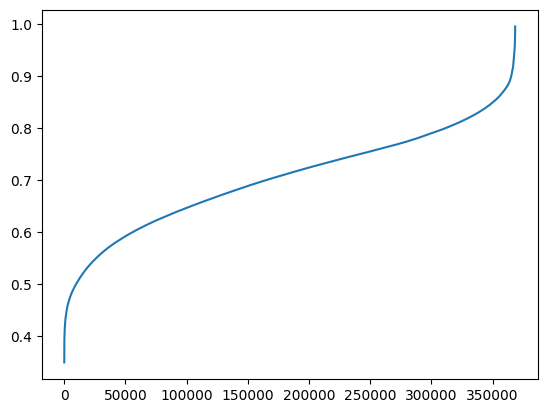

In [71]:
plt.plot(np.sort(df_co_topics.values.reshape(-1)))

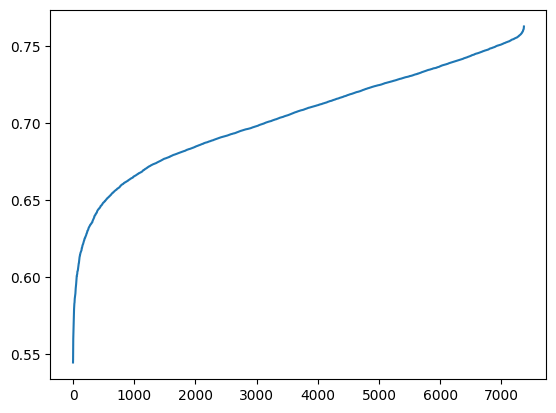

In [52]:
plt.plot(np.sort(df_co_topics.mean(axis=1)))#与 cosine_sim_arr(co_ids_vec)一样

In [364]:
model.document_topics[5]

[(5, 0.085509665),
 (6, 0.13498613),
 (18, 0.07216769),
 (20, 0.07651464),
 (28, 0.13089918),
 (30, 0.048437063),
 (39, 0.32319474)]

In [216]:
patent_co.iloc[5]

Co                                              珠海格力电器股份有限公司
序号                                                       166
标题 (中文)                                              电风扇摇头装置
摘要 (中文)    一种电风扇摇头装置，其特征在于由两个同轴安 装的上传动盘和下传动盘组成，上传动盘的下表面设 ...
申请人                                             珠海格力电器股份有限公司
申请日                                               1994-08-31
申请号                                             CN94219340.7
公开（公告）号                                           CN2202815Y
table                                           patent202210
Name: 5, dtype: object

In [207]:
doc=patent_co.iloc[5]['标题 (中文)']+patent_co.iloc[5]['摘要 (中文)']
processed_doc=[w.strip().lower() for w in jieba.lcut(clean_doc(doc))
                             if not (len(w) < model.args.get('len_below', 2) or w.isdigit() 
                                     or re.match('\d+\.\d+$', w) or w in  model.stop_words)]

bow=model.dictionary.doc2bow(processed_doc)
topic_distribution=model.lda.get_document_topics(bow)

topic_n = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[: model.args.get('top_n_topics', None)]
distribute = np.array(topic_n)[:, 1]
mask = distribute >=  model.args.get('weight_threshold_topics', 0.0)  # 主题权重大于阈值

v_topics = np.array([topics_vec[t[0]] for t in topic_n])[mask]  # 主题向量

w_distribute = (distribute[mask] / np.sum(distribute[mask])).reshape(-1, 1)  # 将归一化结果作为每个技术主题的权重
v_doc = (w_distribute * v_topics).sum(axis=0) 
v_doc

array([ 0.2030736 ,  0.0922246 , -0.03551455,  0.10449886, -0.12880572,
        0.0290949 ,  0.1956326 ,  0.0983133 , -0.04207043, -0.06074722,
        0.15017703,  0.02804194, -0.12025003, -0.01374512,  0.21799757,
       -0.03157167, -0.04001462,  0.12498175,  0.24708626,  0.25752587,
       -0.04233388, -0.18551781,  0.18448228, -0.09561135, -0.04206844,
       -0.07635177, -0.02213457,  0.16615873, -0.11150866, -0.11551209,
       -0.00463161,  0.22030113, -0.3450857 ,  0.00718615,  0.04204296,
       -0.09287149, -0.33693223, -0.01812083, -0.01853391,  0.00887385,
       -0.04125123,  0.36315763, -0.18440225, -0.09419965,  0.11346693,
       -0.03405893,  0.1023463 ,  0.01687693,  0.15789835,  0.09382511,
        0.2168681 ,  0.11375513,  0.18099242, -0.03308989,  0.03784247,
        0.02288984, -0.02367583,  0.18434398, -0.01303859, -0.29882043,
        0.03553789, -0.3125755 ,  0.01978779,  0.13846349,  0.03150993,
        0.12231202,  0.10626524,  0.05516364,  0.1138864 ,  0.08

In [208]:
scores =cosine_similarity(documents_vec,v_doc.reshape(1, -1))
max_index = np.argmax(scores)
scores[max_index]

array([0.99999999])

In [ ]:
scores =cosine_similarity(documents_vec,v_doc.reshape(1, -1))
pd.Series(scores,index=self.sentences.index,name='score')

In [413]:
model.sentences,model.sentences.index

(4          [变幅, 摇头, 电风扇, 一种, 变幅, 摇头, 电风扇, 包括, 扇体, 扇体, 变幅,...
 5          [电风扇, 摇头, 装置, 一种, 电风扇, 摇头, 装置, 两个, 同轴, 传动, 传动,...
 6          [变幅, 摇摆, 电风扇, 一种, 变幅, 摇摆, 电风扇, 包括, 扇体, 扇体, 变幅,...
 15               [彩色, 广播电视, 接收机, 小门, 打开, 状态, __, 小门, 打开, 状态]
 18         [一种, 不开, 可拆卸, 喇叭, 窗盖, 电视, 接收机, 机壳, 一种, 不开, 可拆卸...
                                  ...                        
 1889957    [机器人, 标定, 方法, 系统, 机器人, 涉及, 机器人, 标定, 具体, 涉及, 一种...
 1889958    [一种, 多普勒, 激光, 测风, 雷达, 径向, 风速, 标定, 方法, 旨在, 提供, ...
 1889959    [一种, 晶圆, 激光, 开槽, 装置, 开槽, 方法, 旨在, 提供, 一种, 实现, 双...
 1889960    [一种, 微型, 塑料件, 激光, 焊接, 系统, 焊接, 方法, 提供, 一种, 微型, ...
 1889961    [可拆卸, 电池, 模块, 公开, 可拆卸, 电池, 模块, 涉及, 电池, 模块, 包括,...
 Name: 词语, Length: 1196876, dtype: object,
 Index([      4,       5,       6,      15,      18,      26,      28,      34,
             57,      58,
        ...
        1889945, 1889950, 1889951, 1889953, 1889954, 1889957, 1889958, 1889959,
        1889960, 1889961],
       dtype='int64', length=1196876))

In [433]:
model.document_topics[888],model.corpus[888],model.sentences.iloc[888]

([(8, 0.63835466), (15, 0.03376332), (26, 0.092197396), (39, 0.11488729)],
 [(40, 1),
  (87, 1),
  (102, 1),
  (110, 1),
  (152, 1),
  (165, 1),
  (202, 2),
  (211, 1),
  (218, 4),
  (233, 1),
  (380, 1),
  (399, 1),
  (429, 1),
  (679, 1),
  (692, 1),
  (809, 1),
  (814, 2),
  (850, 1),
  (1240, 1),
  (1723, 1),
  (1736, 1),
  (1774, 1),
  (1781, 2),
  (1807, 1),
  (1854, 1),
  (2509, 1),
  (4822, 1),
  (5592, 1),
  (6125, 1),
  (7088, 2),
  (7389, 1),
  (7390, 1),
  (7391, 1),
  (7392, 1),
  (7393, 1),
  (7394, 1),
  (7395, 1),
  (7396, 3)],
 ['铁基非',
  '晶软',
  '磁合金',
  '属于',
  '功能',
  '材料',
  '磁合金',
  '制备',
  '领域',
  '特别',
  '适合',
  '制备',
  '硼类',
  '中高',
  '饱和',
  '磁感应强度',
  '矩形',
  '磁导率',
  '综合性',
  '新型',
  '铁基非',
  '软磁',
  '合金材料',
  '材料',
  '具体',
  '重量',
  'fe',
  'co',
  'si',
  '采用',
  '铁基非',
  '软磁',
  '合金材料',
  '比较',
  '具有',
  '成份',
  '设计',
  '简单',
  '经济',
  '材料',
  '综合',
  '磁性',
  '机械性能',
  '加工性',
  '材料',
  '使用',
  '范围广',
  '使用',
  '成本低',
  '特点',
  '性能'])

In [437]:
model.sentences.index[888]

2053

In [419]:
jieba.load_userdict('data\\专利分词词库.txt') 

In [440]:
doc=patent_co.loc[2053]['标题 (中文)']+patent_co.loc[2053]['摘要 (中文)']
doc

'铁基非晶软磁合金本发明属于功能材料中软磁合金的制备领域。特别适合制备铁钴硅硼类中高饱和磁感应强度、高矩形比、高磁导率等综合性能好的新型铁基非晶软磁合金材料。该材料的具体化学成分为(重量％)：Fe：81～86％；Co：7-12％；Si：1-3％；B：3～5％。采用本发明铁基非晶软磁合金材料与现有技术相比较，具有成份设计简单、经济，材料综合磁性能和机械性能好，而且可加工性好的。该材料同时还有使用范围广、使用成本低等特点，其性能对比见实施例表。'

In [500]:
vec=model.topic_vec(doc,topics_vec)
scores =cosine_similarity(documents_vec,vec.reshape(1, -1))
scores_map= pd.DataFrame(scores,index=model.sentences.index,columns=['score'])

In [501]:
scores_map=scores_map.join(wd_data['序号']).set_index('序号')
scores_map.sort_values(by='score', ascending=False)

,score
序号,
9580,1.000000
9581,0.999168
438430,0.998177
548002,0.997885
548060,0.997881
...,...
2243902,0.506801
910987,0.506801
1179887,0.506801


In [533]:
doc1='功能材料中软磁合金,磁感应强度、高矩形比、高磁导率等综合性能好的新型铁基非晶软磁合金材料，材料综合磁性能和机械性能好，而且可加工性好'
cosine_similarity(df_lda_w2v.values,model.topic_vec(doc1,topics_vec).reshape(1, -1))[888]

array([0.99328905])

In [535]:
def topic_search(model,doc,topics_vec,df_lda_w2v):
    v_doc=model.topic_vec(doc,topics_vec)
    scores_2d = cosine_similarity(df_lda_w2v.values,v_doc.reshape(1, -1))
    scores = pd.DataFrame(scores_2d,index=df_lda_w2v.index,columns=['score'])
    return scores.sort_values(by='score', ascending=False)

In [536]:
topic_search(model,doc1,topics_vec,df_lda_w2v)

,score
序号,
1532119,0.996259
1532204,0.996253
2075530,0.996132
2076610,0.996131
2075847,0.996130
...,...
1099942,0.543662
1533899,0.543662
1161761,0.543662


In [518]:
doc1='化学成分为(重量％)：Fe：81～86％；Co：7-12％；Si：1-3％；B：3～5％。成份设计简单、经济'
cosine_similarity(documents_vec,model.topic_vec(doc1,topics_vec).reshape(1, -1))[888]

array([0.98582042])

In [519]:
doc1='返回类似字典的对象，通过数组名为键, 提取其中的数组'
cosine_similarity(documents_vec,model.topic_vec(doc1,topics_vec).reshape(1, -1))[888]

array([0.70949333])

In [522]:
doc1='使用摘要技术，将早期对话内容压缩成简短的摘要，保留关键信息，以节省上下文空间'
s=cosine_similarity(documents_vec,model.topic_vec(doc1,topics_vec).reshape(1, -1))
s.argmax()

208275

In [502]:
patent_co.loc[2053]['序号']

9580

In [503]:
scores[888],scores_map.loc[9580]#+分词和停用词

(array([0.99999997]),
 score    1.0
 Name: 9580, dtype: float64)

In [651]:
model.wo.wv.most_similar('处理', topn=10)#similar_by_vector

[('预处理', 0.7108630537986755),
 ('处理过程', 0.672796905040741),
 ('待处理', 0.6448227763175964),
 ('处理场', 0.6012510061264038),
 ('微重床', 0.588450014591217),
 ('理后', 0.5811077356338501),
 ('非税', 0.5803319215774536),
 ('微轻床', 0.5797156691551208),
 ('控水式', 0.5758171677589417),
 ('抛账', 0.5749467611312866)]

In [657]:
model.wo.wv.most_similar(positive='处理', negative=['西安','数据'], topn=10)

[('水洗', 0.07431413978338242),
 ('处理工艺', 0.06933602690696716),
 ('碱洗', 0.06922639906406403),
 ('除油', 0.06454973667860031),
 ('滤出', 0.06145534664392471),
 ('处理机', 0.06032261624932289),
 ('酸洗', 0.058835022151470184),
 ('dtro', 0.05745445936918259),
 ('经此', 0.05540516972541809),
 ('除酸', 0.05218887701630592)]

In [662]:
model.wo.wv.most_similar_to_given('处理', ['西安','数据'])

'西安'

In [653]:
model.wo.wv.similar_by_vector(model.wo.wv['处理'], topn=10)

[('处理', 1.0),
 ('预处理', 0.7108630537986755),
 ('处理过程', 0.672796905040741),
 ('待处理', 0.6448227763175964),
 ('处理场', 0.6012510061264038),
 ('微重床', 0.588450014591217),
 ('理后', 0.5811077356338501),
 ('非税', 0.5803319215774536),
 ('微轻床', 0.5797157287597656),
 ('控水式', 0.5758172273635864)]

In [512]:
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean, cosine, cityblock
1-cosine(documents_vec[888],vec),euclidean(documents_vec[888],vec),cosine_similarity(documents_vec[888].reshape(1, -1),vec.reshape(1, -1))[0][0]

(0.9999999702969528, 0.0005123201951024175, 0.9999999702969528)

In [491]:
%%time
scores_0=cosine_similarity(documents_vec, vec.reshape(1, -1))
scores_0[888]

CPU times: total: 3.11 s
Wall time: 2.35 s


array([1.])

In [488]:
%%time
scores_1=np.apply_along_axis(lambda row: euclidean(row, vec), 1, documents_vec)
scores_1[888]

CPU times: total: 21.6 s
Wall time: 21.6 s


0.0001104346293636575

In [489]:
%%time
scores_2=np.apply_along_axis(lambda row: cityblock(row, vec), 1, documents_vec)
scores_2[888]

CPU times: total: 14.1 s
Wall time: 14.1 s


0.0014140998316220753

In [463]:
processed_doc=[w.strip().lower() for w in jieba.lcut(clean_doc(doc))
                             if not (len(w) < model.args.get('len_below', 2) or w.isdigit() 
                                     or re.match('\d+\.\d+$', w) or w in model.stop_words)]
processed_doc

['铁基非',
 '晶软',
 '磁合金',
 '属于',
 '功能',
 '材料',
 '磁合金',
 '制备',
 '领域',
 '特别',
 '适合',
 '制备',
 '硼类',
 '中高',
 '饱和',
 '磁感应强度',
 '矩形',
 '磁导率',
 '综合性',
 '新型',
 '铁基非',
 '软磁',
 '合金材料',
 '材料',
 '具体',
 '重量',
 'fe',
 'co',
 'si',
 '铁基非',
 '软磁',
 '合金材料',
 '比较',
 '成份',
 '设计',
 '简单',
 '经济',
 '材料',
 '综合',
 '磁性',
 '机械性能',
 '加工性',
 '材料',
 '范围广',
 '成本低',
 '特点',
 '性能']

In [464]:
model.lda.get_document_topics(model.dictionary.doc2bow(processed_doc),minimum_probability=model.args.get('minimum_probability',0.05))#[(8, 0.63835466), (15, 0.03376332), (26, 0.092197396), (39, 0.11488729)],

[(8, 0.6383487), (15, 0.033785224), (26, 0.09219677), (39, 0.11488639)]

In [446]:
scores_map.index.isna().sum()

0

In [538]:
largest_idx = np.argsort(scores.reshape(-1))[-5:][::-1]#flatten [:-6:-1]
scores[largest_idx],model.sentences.iloc[largest_idx]

(array([[0.99999997],
        [0.99916759],
        [0.99817654],
        [0.99788518],
        [0.99788068]]),
 2053      [铁基非, 晶软, 磁合金, 属于, 功能, 材料, 磁合金, 制备, 领域, 特别, 适合...
 2054      [铁基非, 晶软, 磁合金, 属于, 功能, 材料, 磁合金, 制备, 领域, 适合, 制备...
 226638    [一种, 稀土, 磁铁, 公开, 一种, 稀土, 磁铁, 所述, 稀土, 磁铁, 含有, r...
 287803    [一种, 稀土, 磁铁, 公开, 一种, 稀土, 磁铁, 所述, 稀土, 磁铁, 含有, r...
 287835    [一种, 稀土, 磁铁, 公开, 一种, 稀土, 磁铁, 所述, 稀土, 磁铁, 含有, r...
 Name: 词语, dtype: object)

In [548]:
model.sentences.index[largest_idx],scores.reshape(-1)[largest_idx]

(Index([2053, 2054, 226638, 287803, 287835], dtype='int64'),
 array([0.99999997, 0.99916759, 0.99817654, 0.99788518, 0.99788068]))

In [549]:
list(zip(model.sentences.index[largest_idx],scores.reshape(-1)[largest_idx]))

[(2053, 0.9999999702969529),
 (2054, 0.9991675861115017),
 (226638, 0.9981765364897128),
 (287803, 0.9978851755451714),
 (287835, 0.9978806835128099)]

In [572]:
patent_co['申请日']=pd.to_datetime(patent_co['申请日'])
patent_co.dtypes

Co                 object
序号                  int64
标题 (中文)            object
摘要 (中文)            object
申请人                object
申请日        datetime64[ns]
申请号                object
公开（公告）号            object
table              object
dtype: object

In [695]:
df_lda_w2v.index.nunique(),len(df_lda_w2v)

(1196876, 1196876)

In [706]:
#patent_co.loc[model.sentences.index]
table=patent_co.drop_duplicates(['序号']).set_index('序号').loc[df_lda_w2v.index].drop(columns=['申请人','摘要 (中文)'])
table['文档长度']=model.sentences.map(len).to_list()
table

,Co,标题 (中文),申请日,申请号,公开（公告）号,table,文档长度
序号,,,,,,,
165,珠海格力电器股份有限公司,变幅摇头电风扇,1994-08-31,CN94219339.3,CN2201504Y,patent202210,60
166,珠海格力电器股份有限公司,电风扇摇头装置,1994-08-31,CN94219340.7,CN2202815Y,patent202210,36
167,珠海格力电器股份有限公司,变幅摇摆电风扇,1994-08-31,CN94109207.0,CN1118043A,patent202210,60
330,四川长虹电器股份有限公司,彩色广播电视接收机(1),1995-10-16,CN95310371.4,CN3044990D,patent202210,10
344,四川长虹电器股份有限公司,一种不开后罩即可拆卸喇叭窗盖的电视接收机机壳,1995-11-24,CN95242445.2,CN2248433Y,patent202210,62
...,...,...,...,...,...,...,...
2781354,深圳市大寰机器人科技有限公司,机器人标定方法、系统及机器人,2024-03-01,CN202410231929.9,CN117798937A,patent202404,97
2781355,珠海光恒科技有限公司,一种多普勒激光测风雷达径向风速标定方法,2024-03-01,CN202410234087.2,CN117805792A,patent202404,71
2781356,珠海市申科谱工业科技有限公司,一种晶圆激光开槽装置及开槽方法,2024-03-01,CN202410233264.5,CN117798508A,patent202404,96


In [708]:
df_lda_w2v.index

Index([    165,     166,     167,     330,     344,     496,     508,     557,
           889,     898,
       ...
       2781340, 2781346, 2781347, 2781350, 2781351, 2781354, 2781355, 2781356,
       2781357, 2781360],
      dtype='int64', name='序号', length=1196876)

In [713]:
len(model.sentences.iloc[0]),len(model.sentences.iloc[-1])

(60, 88)

In [714]:
table['文档长度'].describe()

count    1.196876e+06
mean     8.521023e+01
std      2.607785e+01
min      1.000000e+01
25%      7.200000e+01
50%      9.100000e+01
75%      1.030000e+02
max      1.607000e+03
Name: 文档长度, dtype: float64

In [715]:
payload=table.to_dict(orient='records')
len(payload),len(df_lda_w2v)

(1196876, 1196876)

In [718]:
payload[0],payload[-1]

({'Co': '珠海格力电器股份有限公司',
  '标题 (中文)': '变幅摇头电风扇',
  '申请日': Timestamp('1994-08-31 00:00:00'),
  '申请号': 'CN94219339.3',
  '公开（公告）号': 'CN2201504Y',
  'table': 'patent202210',
  '文档长度': 60},
 {'Co': '长安绿电科技有限公司',
  '标题 (中文)': '可拆卸式电池模块',
  '申请日': Timestamp('2024-03-04 00:00:00'),
  '申请号': 'CN202420403622.8',
  '公开（公告）号': 'CN220710520U',
  'table': 'patent202404',
  '文档长度': 88})

In [717]:
import pickle
with open('data\patent_payload_先进制造_2024.pkl', 'wb') as file:
    pickle.dump(payload, file)

In [604]:
co_ids_vec_t.index

Index(['Dexta Robotics', 'TCL华星光电技术有限公司', 'TCL科技集团股份有限公司', '一道新能源科技股份有限公司',
       '七星电气股份有限公司', '七腾机器人有限公司', '万华新材料有限公司', '万向一二三股份公司', '万马科技股份有限公司',
       '万鼎硅钢集团有限公司',
       ...
       '黄山富田精工智造股份有限公司', '黄山市光锐通信股份有限公司', '黄石晨信光电股份有限公司', '黑龙江哈工石墨科技有限公司',
       '黑龙江林海华安新材料股份有限公司', '黑龙江省发现者机器人股份有限公司', '鼎桥通信技术有限公司', '龙微科技无锡有限公司',
       '龙腾半导体股份有限公司', '龙芯中科技术股份有限公司'],
      dtype='object', name='Co', length=7370)

In [614]:
df_co.columns

Index(['公司序号', '公司简称', '工商全称', '行业'], dtype='object')

In [632]:
coinfo=df_co[df_co.行业=='先进制造'].drop_duplicates(['工商全称']).set_index('工商全称').drop(columns=['行业'])
coinfo

,公司序号,公司简称
工商全称,,
北京若愚智能设备有限公司,8651,WiPlug推
深圳市卡迪尔通讯技术有限公司,8652,21克手机
上海金卓科技有限公司,8653,金卓网络科技
深圳市百分之百数码科技有限公司,8654,百分之百数码
上海优爱宝智能机器人科技股份有限公司,8655,优爱宝机器人
...,...,...
佛山道善智能机器人有限公司,18708,道善智能
上海百功半导体有限公司,18709,百功半导体
浙江紫明低温科技有限公司,18710,紫明低温


In [720]:
payload=coinfo.loc[co_ids_vec_t.index].reset_index().to_dict(orient='records')
len(payload),len(co_ids_vec_t)

(7370, 7370)

In [721]:
payload[0],co_ids_vec_t.iloc[0].name

({'Co': 'Dexta Robotics', '公司序号': 8872, '公司简称': 'Dexta Robotics'},
 'Dexta Robotics')

In [724]:
co_ids_vec_i=pd.read_parquet('data\patent_co_vec_先进制造_2000.parquet')
cosine_sim_df(co_ids_vec_i, triu=True)

Co,上海贝岭股份有限公司,中兴通讯股份有限公司,南京熊猫电子股份有限公司,四川长虹电器股份有限公司,国电南京自动化股份有限公司,大连路明发光科技股份有限公司,安泰科技股份有限公司,广东风华高新科技股份有限公司,新源动力股份有限公司,新疆众和股份有限公司,江苏中天科技股份有限公司,江苏亨通光电股份有限公司,江苏海鸥冷却塔股份有限公司,江苏长电科技股份有限公司,沈阳新松机器人自动化股份有限公司,深圳市力可兴电池有限公司,烽火通信科技股份有限公司,珠海格力电器股份有限公司,福耀玻璃工业集团股份有限公司,贵研铂业股份有限公司
Co,,,,,,,,,,,,,,,,,,,,
上海贝岭股份有限公司,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
中兴通讯股份有限公司,0.952813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
南京熊猫电子股份有限公司,0.859238,0.890830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
四川长虹电器股份有限公司,0.900869,0.957978,0.964147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
国电南京自动化股份有限公司,0.885073,0.950877,0.824693,0.913801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
大连路明发光科技股份有限公司,0.765322,0.760664,0.883618,0.826655,0.682253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
安泰科技股份有限公司,0.768442,0.793406,0.959115,0.894475,0.722456,0.935773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
广东风华高新科技股份有限公司,0.788513,0.826107,0.938977,0.901017,0.758293,0.812703,0.934231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
新源动力股份有限公司,0.733053,0.753153,0.925773,0.857046,0.673836,0.923266,0.952314,0.869154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [727]:
for i  in range(2000,2025):
    co_ids_vec_i=pd.read_parquet(f'data\patent_co_vec_先进制造_{i}.parquet')
    df_i=cosine_sim_df(co_ids_vec_i, triu=True)
    print(i, df_i.shape)
    df_i.to_excel(f'data\patent_co_cosine_sim_先进制造_{i}.xlsx')

2012 (1038, 1038)
2013 (1354, 1354)
2014 (1746, 1746)
2015 (2366, 2366)
2016 (3108, 3108)
2017 (3765, 3765)
2018 (4289, 4289)


KeyboardInterrupt: 

In [731]:
import gc
gc.collect()

6713056

In [3]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [4]:
async def save_to_csv(df, year):
    await asyncio.to_thread(df.to_csv, f'data/patent_co_cosine_sim_先进制造_{year}.csv', encoding="utf_8_sig")#excel这个转换比较慢
    
async def process_year(i):
    co_ids_vec_i = await asyncio.to_thread(pd.read_parquet,f'data/patent_co_vec_先进制造_{i}.parquet')
    df_i =  await asyncio.to_thread(cosine_sim_df,co_ids_vec_i, True)
    print(f'Start processing {i, df_i.shape}')
    await save_to_csv(df_i, i)
    print(f'Finished processing {i}')
    del co_ids_vec_i, df_i
    gc.collect()

async def process_main(years, batch_size):
    for i in range(0, len(years), batch_size):
        tasks = [process_year(year) for year in years[i:i + batch_size]]
        await asyncio.gather(*tasks)

In [5]:
years = range(2018,2025)
batch_size = 3
asyncio.run(process_main(years,batch_size))

Start processing (2018, (4289, 4289))
Start processing (2019, (4713, 4713))
Start processing (2020, (5082, 5082))
Finished processing 2018
Finished processing 2019
Finished processing 2020
Start processing (2021, (6616, 6616))
Start processing (2022, (7048, 7048))
Start processing (2023, (7362, 7362))
Finished processing 2021
Finished processing 2022
Finished processing 2023
Start processing (2024, (7370, 7370))
Finished processing 2024


In [645]:
payloads=[]
vectors=[]
for i  in range(2000,2025):
    co_ids_vec_i=pd.read_parquet(f'data\patent_co_vec_先进制造_{i}.parquet')
    tmp=coinfo.loc[co_ids_vec_i.index]
    tmp['观察年']=i
    payloads+=tmp.reset_index().to_dict(orient='records')
    vectors+=co_ids_vec_i.values.tolist()
    print(i,len(payloads),len(vectors))

2000 20 20
2001 56 56
2002 107 107
2003 174 174
2004 259 259
2005 364 364
2006 516 516
2007 739 739
2008 1066 1066
2009 1516 1516
2010 2128 2128
2011 2946 2946
2012 3984 3984
2013 5338 5338
2014 7084 7084
2015 9450 9450
2016 12558 12558
2017 16323 16323
2018 20612 20612
2019 25325 25325
2020 30407 30407
2021 37023 37023
2022 44071 44071
2023 51433 51433
2024 58803 58803


In [650]:
payloads[-1]

{'Co': '龙芯中科技术股份有限公司', '公司序号': 14927, '公司简称': '龙芯中科', '观察年': 2024}

In [646]:
with open('data\patent_co_payloads_先进制造.pkl', 'wb') as file:
    pickle.dump(payloads, file)
with open('data\patent_co_vectors_先进制造.pkl', 'wb') as file:
    pickle.dump(vectors, file)

In [627]:
len(model.topic_documents_dict)

50

In [628]:
%%time
word_entropy=model.topic_word_entropy_corpus()
word_entropy.head(20)

CPU times: total: 4min 23s
Wall time: 4min 25s


,ebc,eic_sum,ec,word
406,5.426343,733.771230,3981.694082,系统
744,5.436941,731.972858,3979.692944,控制
111,5.518216,717.666793,3960.240168,问题
109,5.524418,715.257235,3951.379757,解决
331,5.459413,723.168248,3948.074030,设备
112,5.458234,710.853541,3880.004633,降低
493,5.483613,706.678964,3875.154300,有效
1106,5.480125,703.694720,3856.335048,效率
920,5.462806,700.923821,3829.010799,避免
231,5.489151,691.777228,3797.269383,过程


In [629]:
word_entropy.to_excel('data/patent_word_entropy_先进制造.xlsx')

In [209]:
(df_lda_w2v.iloc[max_index]-documents_vec[max_index]).sum()

0.0

In [210]:
df_lda_w2v.iloc[max_index].name

166

In [211]:
patent_co.loc[patent_co.序号==166,'摘要 (中文)']

5    一种电风扇摇头装置，其特征在于由两个同轴安 装的上传动盘和下传动盘组成，上传动盘的下表面设 ...
Name: 摘要 (中文), dtype: object

In [212]:
doc#相似主题

'电风扇摇头装置一种电风扇摇头装置，其特征在于由两个同轴安 装的上传动盘和下传动盘组成，上传动盘的下表面设 有凸起物，下传动盘的上表面设有供放置凸起物的径 向凹槽。该装置体积小，结构紧凑，为小型风扇的摇 头，特别是扇体的中心轴搭接在扇壳两端的这类电风 扇的变幅摇头摆动提供了可能性。'

In [321]:
importlib.reload(w2v_lda)
from w2v_lda import *
tmp=W2vLda(sentences=None,wd_data=patent_co[:100],stop_words=Stopwords,suffix='111')

In [284]:
tmp.sentences

0     [竖式, 烧结, 冷却, 一种, 具有, 环形, 风道, 密闭, 结构, 竖式, 烧结, 冷...
1     [具有, 抗静电, 轻垢, 液体, 洗衣, 洗涤剂, 提供, 一种, 透明, 半透明, 具有...
2     [麦白, 霉素, 胃溶片, 生产工艺, 技术, 一种, 麦白, 霉素, 胃溶片, 生产工艺,...
4     [变幅, 摇头, 电风扇, 一种, 变幅, 摇头, 电风扇, 包括, 扇体, 特征, 扇体,...
5     [电风扇, 摇头, 装置, 一种, 电风扇, 摇头, 装置, 特征, 两个, 同轴, 传动,...
                            ...                        
92    [电池, 外观, 主创, 部分, 电池, 外包装, 图案, 色彩, 组合, 请求, 保护, 色彩]
93    [挂板, 五号, 视图, 视图, 相同, 省略, 视图, 仰视, 相同, 省略, 仰视, 请...
94    [挂板, 七号, 视图, 视图, 相同, 省略, 视图, 仰视, 相同, 省略, 仰视, 请...
98    [带电, 车削, 加工, 装置, 一种, 带电, 车削, 加工, 装置, 可控硅, 供电, ...
99    [影碟机, 包装盒, 相同, 故略, 视图, 仅为, 底色, 特殊, 设计, 要求, 故略,...
Name: 标题 (中文), Length: 68, dtype: object

In [285]:
tmp.group_ids

,Co,序号
0,云南铝业股份有限公司,"[1106, 1213]"
1,佛山电器照明股份有限公司,[174]
2,北京科技大学,[603]
3,南京熊猫电子股份有限公司,"[557, 898, 1053, 1274]"
4,唐山钢铁集团有限责任公司,"[389, 393, 404, 470, 471, 472, 504, 521, 538, ..."
5,四川长虹电器股份有限公司,"[330, 344]"
6,安阳钢铁股份有限公司,[603]
7,山东省药用玻璃股份有限公司,[271]
8,山东金泰集团股份有限公司,[142]
9,山东鲁抗医药股份有限公司,[154]


In [297]:
words=[]
for topic_id in range(model.lda.num_topics):
    word_distribute=model.lda.show_topic(topicid=topic_id, topn=30)
    words +=[(word,topic_id) for word, _ in word_distribute]
    
df_wt=pd.DataFrame(words,columns=['word','topic'])
df_wt

,word,topic
0,目标,0
1,测量,0
2,切换,0
3,沟槽,0
4,触发,0
...,...,...
1495,短路,49
1496,工作人员,49
1497,橡胶,49
1498,水流,49


In [307]:
df_wt.value_counts()[:32]

word
一种    36
包括    28
进行    22
用于    19
公开    17
提供    15
涉及    13
方法    12
提高    12
设置    10
装置     9
连接     8
实现     8
能够     8
具有     8
之间     7
应用     5
形成     5
表面     5
处理     5
一个     4
结构     4
位于     4
方向     4
执行     4
多个     4
效率     4
对应     4
至少     4
通信     4
确定     4
获取     4
Name: count, dtype: int64

In [353]:
df_wt=model.topics_words(topn=30)
df_wt.value_counts()[:20]

word
效率    7
接收    6
输入    5
情况    5
生成    5
过程    5
结构    5
位于    5
输出    4
性能    4
不同    4
配置    4
执行    4
计算    4
指令    4
实时    4
需求    3
类型    3
一侧    3
设有    3
Name: count, dtype: int64

In [299]:
'一种' in model.stop_words

False

In [300]:
'一种' in Stopwords

False

In [315]:
stop_1=[
'一种',
'每种',
'每次',
'根据',
'第一',
'第二',
'第三',
'所述',
'包括',
'进行',
'获取',
'对应',
'确定',
'基于',
'得到',
'提供',
'通过',
'方法',
'装置',
'请求',
'申请',
'一个',
'两个',
'多个',
"公开",
'应用',
"用于",
"使用",
"能够",
"实现",
"用以",
"上述",
"提高",
'采用',
'利用',
'获得',
'提升',
'之间',
'多笔',
'多种',
'是否',
'涉及',
'处理',
'形成',
'至少',
'具有']
stop_1+=df_wt.word.value_counts()[:16].index.tolist()

In [319]:
Stopwords=sorted(set(i.strip() for i in Stopwords+stop_1)) 
len(Stopwords)

6956

In [320]:
with open('data\\专利停用词表2024.txt', "w",encoding='UTF-8') as file:
    for item in Stopwords:
        file.write((item) + "\n")